In [1]:
import torch
from torch import nn
import dltools

In [ ]:
def transpose_qkv(X, num_heads):
    batch_size, num_queries, num_hiddens = X.shape
    assert num_hiddens % num_heads == 0, "num_hiddens must be divisible by num_heads"
    per_head_size = num_hiddens // num_heads  # ✅ 强制整数
    X = X.reshape(batch_size, num_queries, num_heads, per_head_size)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(batch_size * num_heads, num_queries, per_head_size)


In [3]:
def transpose_output(X, num_heads):
    batch_size = X.shape[0] // num_heads
    num_queries = X.shape[1]
    per_head_size = X.shape[2]
    X = X.reshape(batch_size, num_heads, num_queries, per_head_size)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(batch_size, num_queries, num_heads * per_head_size)


In [4]:
class MutiHeadAttention(nn.Module):
    def __init__(self, key_size,query_size,value_size,num_hiddens,num_heads,dropout,bia=False, **kwargs):
        super().__init__( **kwargs)
        self.num_heads = num_heads
        self.attention = dltools.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size,num_hiddens,bias=bia)
        self.W_k = nn.Linear(key_size,num_hiddens,bias=bia)
        self.W_v = nn.Linear(value_size,num_hiddens,bias=bia)
        self.W_o = nn.Linear(num_hiddens,num_hiddens,bias=bia)

    def forward(self,queries,keys,values,valid_lens):
        queries = transpose_qkv(self.W_q(queries),self.num_heads)
        keys = transpose_qkv(self.W_k(keys),self.num_heads)
        values = transpose_qkv(self.W_v(values),self.num_heads)
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens,repeats=self.num_heads,dim=0)

        output = self.attention(queries,keys,values,valid_lens)
        output_concat = transpose_output(output,self.num_heads)

        return self.W_o(output_concat)

In [5]:
class AttentionDecoder(dltools.Decoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        @property
        def attention_weighted(self):
            raise NotImplemented

In [ ]:
class Seq2SeqMutiHeadAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size,embed_size,num_hiddens,num_layers,num_heads,dropout=0,**kwargs):
        super().__init__(**kwargs)
        self.attention = MutiHeadAttention(num_hiddens,num_hiddens,num_hiddens,num_hiddens,num_heads,dropout)
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens,num_hiddens,num_layers,dropout=dropout)
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs,enc_valid_lens, *args):
        outputs,hidden_state = enc_outputs
        return (outputs.permute(1,0,2),hidden_state,enc_valid_lens)
    

    def forward(self,X,state):
        enc_outputs,hidden_state,enc_valid_lens = state
        X = self.embedding(X)
        X = X.permute(1,0,2)
        outputs,self._attention_weights = [],[]
        for x in X:
            query = torch.unsqueeze(hidden_state[-1],dim=1)
            context = self.attention(query,enc_outputs,enc_outputs,enc_valid_lens)
            x = torch.cat((context,torch.unsqueeze(x,dim=1)),dim=-1)
            out,hidden_state = self.rnn(x.permute(1,0,2),hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention_weights)

        outputs = self.dense(torch.cat(outputs,dim=0))
        return outputs.permute(1,0,2),[enc_outputs,hidden_state,enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.020, 7571.9 tokens/sec on cuda:0


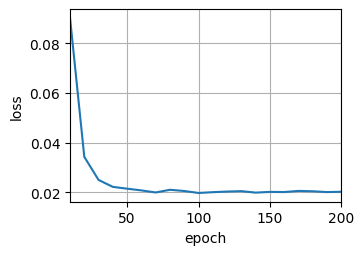

In [7]:
embed_size,num_hiddens,num_layers,dropout,num_heads = 100,100,2,0.1,5
batch_size,num_steps = 64,10
lr,num_epochs,device = 0.005,200,dltools.try_gpu()

train_iter,src_vocab,tgt_vocab = dltools.load_data_nmt(batch_size,num_steps)
encoder = dltools.Seq2SeqEncoder(len(src_vocab),embed_size,num_hiddens,num_layers,dropout)
decoder = Seq2SeqMutiHeadAttentionDecoder(len(tgt_vocab),embed_size,num_hiddens,num_layers,num_heads,dropout)
net = dltools.EncoderDecoder(encoder,decoder)
dltools.train_seq2seq(net,train_iter,lr,num_epochs,tgt_vocab,device)